In [13]:
import torch

import lightning as L
import numpy as np
import matplotlib.pyplot as plt

import sys
extra_path = "/n/home08/albergo/projects/discrete-diffusion/leaps/"
if extra_path not in sys.path:
    sys.path.append(extra_path)
    
from src.modules.trainer import IsingLightningModule
from src.modules.sampler import DiscreteJarzynskiIntegrator



In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())
print(device)

def grab(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return x

def ess(At):
    return torch.mean(torch.exp(At))**2 / torch.mean(torch.exp(2*At))

True
cuda:0


### Load model

In [5]:
L        = 15
target     = 'ising'
run_num  = '4'
# epoch    = 0
# step     = 200
prior    = 'normal'
base_dir = '/n/holylabs/LABS/albergo_lab/Lab/albergo/projects/discrete-diffusion/leaps'

fpath = f"{base_dir}/{target}/L{L}/expts/{target}-L{L}-{run_num}/ckpts/"
# ckpt  = f"epoch={epoch}-step={step}.ckpt"
ckpt  = f"last.ckpt"

print(fpath+ckpt)

/n/holylabs/LABS/albergo_lab/Lab/albergo/projects/discrete-diffusion/leaps/ising/L15/expts/ising-L15-4/ckpts/last.ckpt


In [6]:
model = IsingLightningModule.load_from_checkpoint(fpath + ckpt)

Js: tensor(0.4000) tensor(0.)
mus: tensor(0.) tensor(0.)
Bs: tensor(0.) tensor(0.)
betas: tensor(0.7000) tensor(0.7000)


In [ ]:
model

### Sample model

In [24]:
final_t = 1.0
n_step = 100
L = 15
bs = 100
t_set = final_t*torch.rand(n_step - 1) # -1 because we append 1.0 at the end
t_set = torch.cat((torch.tensor([0.0]), t_set, torch.tensor([final_t])))
# Sort the numbers to get randomly spaced samples
ts = torch.sort(t_set).values.to(device)
eps = torch.tensor(n_step).to(device)
jit = DiscreteJarzynskiIntegrator(model.Energy, eps, ts, Qt_net=model.net, transport = True, 
                              n_save = 50, resample = False, resample_thres = 0.5)


sigma_vec = 2 * torch.randint(0,2,size=(bs, L, L)).float().to(device) - 1
sigmas, As = jit.rollout(sigma_vec) 

sigmas = sigmas.detach()
As     = As.detach()

### look at samples

In [25]:
def visualize_lattices(phi, n_rows = 2, n_cols = 5, save = None):
    """
    Visualize a subset of the lattices in a grid.

    Parameters:
    - phi: A tensor of shape [bs, L, L] representing the batch of lattices.
    - n_rows: Number of rows in the subplot grid.
    - n_cols: Number of columns in the subplot grid.
    - title: The title of the plot.
    """
    bs, L, _ = phi.shape
    n_plots = min(n_rows * n_cols, bs)
    print("N ROW:", n_rows)
    print("N COL:", n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 5))

    indices = np.random.choice(bs, n_plots, replace=False)  # Randomly select lattice indices
        
    for i, idx in enumerate(indices):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        # cmap = sns.cubehelix_palette(start=-0.8, rot=0.4, gamma=1.0, dark=0.2, light=0.9, reverse=False, as_cmap=True)
        v = 0.5
        im = ax.imshow(phi[idx], cmap='viridis', origin='lower', vmin=-v, vmax=v)
        ax.axis('off') 

    fig.subplots_adjust( wspace=0.1, hspace=-0.5)
    
    if save is not None:
        plt.savefig(save, bbox_inches='tight')
    # plt.tight_layout()
    plt.show()

N ROW: 2
N COL: 5


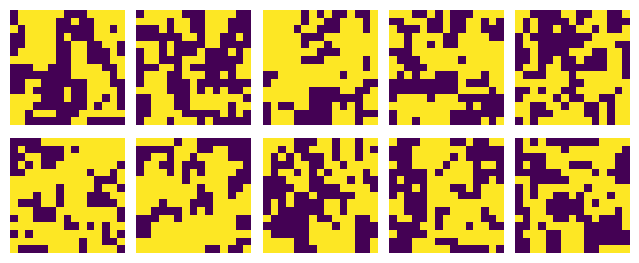

In [26]:
visualize_lattices(grab(sigmas[-1]))